In [1]:
pip install jsmetrics

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install cartopy

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install h5netcdf 

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install xarray

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install cftime

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install cmcrameri

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install cmasher

Note: you may need to restart the kernel to use updated packages.


In [8]:
import xarray as xr
import numpy as np
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import math
from collections import Counter
from cmcrameri import cm
import FuncionesERA5 as fsE5
import jsmetrics

In [9]:
def lineplot_setup(xmin,xmax,xlab,ylab,ymin=None,ymax=None,title=None,legend=False):
    # especificar limites minimos y maximos del grafico
    plt.xlim([xmin,xmax])
    plt.ylim([ymin,ymax])
    # cuadrilla interna del grafico
    plt.grid(linestyle='--',alpha=0.66)
    plt.minorticks_on()
    # hacer las etiquetas de ambos ejes mas grandes
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.xlabel(xlab,fontsize=10)
    plt.ylabel(ylab,fontsize=10)
    plt.title(title,fontsize=11)
    if legend:
        plt.legend(fancybox=True,shadow=True,fontsize=8)

### **<font color="Purple"> Datos de ERA-5 </font>**

In [10]:
fileu_era5 = 'datasets/u_200_500_daily1979-2019.nc'

In [11]:
u_ds = xr.open_dataset(fileu_era5)
u_era5 = u_ds['u']

In [12]:
lonsE5 = u_era5.longitude
latsE5 = u_era5.latitude

### **<font color="Purple"> Datos de HadGEM3 </font>**

In [13]:
u_99= 'datasets/uaday200hpa_99_mx.nc'
u_14='datasets/uaday200hpa_14_mx.nc'

In [14]:
# Abrir archivos y seleccionar variables a usar 
u_ds99=xr.open_dataset(u_99)
ua99=u_ds99['ua']  
u_ds14=xr.open_dataset(u_14)
ua14=u_ds14['ua']

In [15]:
latsHG = ua99.lat
lonsHG = ua99.lon

----
## **<font color="crimson"> HadGEM3 vs ERA-5 (anual) </font>**

#### **<font color="Purple"> Datos de viento ERA-5 (anual) </font>**

In [16]:
#Seleccionar solo 200 hPa 
u200E5 = u_era5.sel(level=200)

In [17]:
u200E5_anual=u200E5.mean(dim='time') 

#### **<font color="Purple"> Datos de viento HadGEM3 (anual) </font>**

In [18]:
u200HG = xr.concat([ua99, ua14], dim='time')

In [19]:
u200HG_anual = u200HG.mean(dim='time')

---
## **<font color="crimson"> HadGEM3 vs ERA-5 (DJF) </font>**


#### **<font color="Purple"> Datos HadGEM3 de viento zonal en DJF</font>**

In [20]:
u200HG_season=u200HG.groupby(u200HG.time.dt.season).mean(dim='time') 
uHG_DJF = u200HG_season[0]


#### **<font color="Purple"> Datos ERA-5 de viento zonal en DJF</font>**


In [21]:
u200E5_season = u200E5.groupby(u200E5.time.dt.season).mean(dim='time')
uE5_DJF = u200E5_season[0]

In [22]:
import cmasher

In [23]:
cmashermap=cmasher.savanna_r

###### <h1  style="color:rebeccapurple; font-size:17px;"><i> Estadística </i> </h1>
#####   - `Anual` y `en una región`



In [24]:
# este es para HadGEM
def recortes1a1 (ua1,latA,latB,lonA,lonB,año):
    """
    Esta función nos recortará los datos (años,latitudes, longitudes) para usarlos en otras funciones 
    ua1,va1: viento (zonal,meridional) de la simulación 1 
    ua2,va2:  viento (zonal,meridional) de la simulación 2
    latA,latB: recorte de latitudes de menor (A) a mayor (B)
    lonA,lonB: recorte de longitudes de menor (A) a mayor (B)
    """
    ua1["plev"]=ua1["plev"]/100

    ua1['units']='hPa'
    
    ua1 = ua1.sel(lat=slice(latA, latB), lon=slice(360-lonB, 360-lonA)).where(ua1.time.dt.year > año, drop=True)

    #Recorte para la temporada invernal en el HN
    
    ua1=ua1.where((ua1.time.dt.month==12)| (ua1.time.dt.month==1)| (ua1.time.dt.month==2),drop=True)
   
    return {'ua1': ua1}

In [25]:
#este es para HadGEM
def js_pos_intens (ua1):
    """
    Esta función encuentra la posición promedio y la intensidad, usando el método de Woollings et al. 2010
    ua1: Viento zonal de la simulación 1 (ua1)
    ua2: Viento zonal de la simulación 2 (ua2)
    nivel: a qué nivel de presión se hará el cálculo, en Pa
    
    """

    #nivel = ua1.plev
    #Convertir el tiempo a gregoriano 
    ua1 = ua1.convert_calendar(calendar='gregorian', align_on='year')
    
    #Usamos jsmetrics statistics
    sim1 = jsmetrics.jet_statistics.woollings_et_al_2010(ua1,filter_freq=4,window_size=20)
    
    #POSICIÓN
    sim1_p=sim1["jet_lat"].groupby(sim1["jet_lat"].time.dt.year).mean() 
    
    #VELOCIDAD
    sim1_v=sim1["jet_speed"].groupby(sim1["jet_speed"].time.dt.year).mean()  
    
    return {'Posición del jet en simulación 1':sim1_p,
            'Velocidad del jet en simulación 1':sim1_v
            }

In [26]:
#recortes1a1 tiene argumentos(ua1,latA,latB,lonA,lonB,año1)
recorteR = recortes1a1(u200HG,10,40,67,129,1978)

In [27]:
recorteR #ya está en hPa

{'ua1': <xarray.DataArray 'ua' (time: 3240, lat: 25, lon: 33)> Size: 11MB
 array([[[17.03125   , 13.65625   , 11.986328  , ..., 11.627686  ,
           9.355225  ,  6.89624   ],
         [17.483643  , 13.547607  , 12.538574  , ..., 15.182373  ,
          12.387207  ,  9.038574  ],
         [18.399658  , 14.196533  , 13.086914  , ..., 18.341064  ,
          15.794678  , 12.447266  ],
         ...,
         [40.214355  , 40.010742  , 39.984863  , ..., 51.630127  ,
          49.372314  , 46.753174  ],
         [46.66455   , 46.427734  , 46.508545  , ..., 51.97705   ,
          50.6167    , 48.84497   ],
         [51.07251   , 51.0459    , 51.546143  , ..., 52.349854  ,
          51.81543   , 50.86841   ]],
 
        [[12.787598  , 13.595459  , 13.628906  , ...,  9.232422  ,
           6.8669434 ,  2.9448242 ],
         [18.48706   , 18.45459   , 18.21167   , ..., 10.957031  ,
           7.708008  ,  3.7988281 ],
         [21.763916  , 21.284424  , 20.612793  , ..., 11.952881  ,
          

In [28]:
#js_pos_intens tiene argumentos (ua1,ua2,nivel) NIVEL ESTÁ EN hPa o en Pa???
POS_VEL = js_pos_intens(recorteR['ua1'])

In [29]:
POS_VEL

{'Posición del jet en simulación 1': <xarray.DataArray 'jet_lat' (year: 36)> Size: 288B
 array([33.671875  , 30.70833333, 33.30555556, 32.33333333, 33.02777778,
        32.73611111, 30.68055556, 31.13888889, 33.40277778, 32.5       ,
        33.45833333, 32.51388889, 31.38888889, 29.61111111, 30.55555556,
        33.59722222, 31.80555556, 29.59722222, 31.98611111, 31.68055556,
        31.84722222, 32.65277778, 33.56944444, 31.27777778, 33.11111111,
        29.5       , 34.31944444, 31.72222222, 30.83333333, 35.59722222,
        32.91666667, 31.875     , 28.5       , 33.75      , 34.77777778,
        31.515625  ])
 Coordinates:
     plev     float64 8B 250.0
     units    <U3 12B 'hPa'
   * year     (year) int64 288B 1979 1980 1981 1982 1983 ... 2011 2012 2013 2014,
 'Velocidad del jet en simulación 1': <xarray.DataArray 'jet_speed' (year: 36)> Size: 288B
 array([43.00248152, 45.5051937 , 48.0577625 , 47.21879916, 41.99009748,
        49.00541644, 43.0318697 , 44.95540083, 43.79065333, 

In [30]:
def varianza1a1(sim1_p, sim1_v):
    # Calcular varianza y media para la posición y velocidad
    var_1p = sim1_p.var().round(2)
    mean_1p = sim1_p.round(2)
    var_1v = sim1_v.var().round(2)
    mean_1v = sim1_v.round(2)
    
    return {'var_POS':var_1p, 'mean_POS':mean_1p, 'var_VEL': var_1v, 'mean_VEL':mean_1v }

In [31]:
# varianza1a1 tiene arumentos (sim1_p, sim1_v):
POSyVEL = varianza1a1(POS_VEL['Posición del jet en simulación 1'],POS_VEL['Velocidad del jet en simulación 1'] )

In [32]:
POSyVEL

{'var_POS': <xarray.DataArray 'jet_lat' ()> Size: 8B
 array(2.38)
 Coordinates:
     plev     float64 8B 250.0
     units    <U3 12B 'hPa',
 'mean_POS': <xarray.DataArray 'jet_lat' (year: 36)> Size: 288B
 array([33.67, 30.71, 33.31, 32.33, 33.03, 32.74, 30.68, 31.14, 33.4 ,
        32.5 , 33.46, 32.51, 31.39, 29.61, 30.56, 33.6 , 31.81, 29.6 ,
        31.99, 31.68, 31.85, 32.65, 33.57, 31.28, 33.11, 29.5 , 34.32,
        31.72, 30.83, 35.6 , 32.92, 31.88, 28.5 , 33.75, 34.78, 31.52])
 Coordinates:
     plev     float64 8B 250.0
     units    <U3 12B 'hPa'
   * year     (year) int64 288B 1979 1980 1981 1982 1983 ... 2011 2012 2013 2014,
 'var_VEL': <xarray.DataArray 'jet_speed' ()> Size: 8B
 array(5.92)
 Coordinates:
     plev     float64 8B 250.0
     units    <U3 12B 'hPa',
 'mean_VEL': <xarray.DataArray 'jet_speed' (year: 36)> Size: 288B
 array([43.  , 45.51, 48.06, 47.22, 41.99, 49.01, 43.03, 44.96, 43.79,
        42.96, 42.94, 43.52, 45.96, 43.82, 46.05, 40.5 , 45.36, 45.02,
      

In [33]:
# Datos para graficar varianza y medias de HadGEM
mean_POS = POSyVEL['mean_POS']
mean_VEL = POSyVEL['mean_VEL']
var_POS = POSyVEL['var_POS'], 
var_VEL = POSyVEL['var_VEL']

----
## **<font color="crimson"> HadGEM3 vs ERA-5 (anual) </font>**


#### **<font color="Purple"> Datos ERA-5 de viento zonal </font>**


#### ERA-5

In [34]:
mx_slicedE5 = u_era5.sel(latitude=slice(40,10)) 
mx_slicedE5 = mx_slicedE5.sel(longitude=slice(231,293)) 

In [35]:
mx_slicedE5 = mx_slicedE5.rename({'latitude': 'lat', 'longitude': 'lon','level':'plev'})

In [36]:
mx_slicedE5=mx_slicedE5.rename('ua') 

In [37]:
mx_slicedE5

<xarray.DataArray 'ua' (time: 14761, plev: 2, lat: 40, lon: 83)> Size: 784MB
[98013040 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 118kB 1979-01-01T11:30:00 ... 2019-05-31T1...
  * lon      (lon) float32 332B 231.0 231.8 232.5 233.2 ... 291.0 291.8 292.5
  * lat      (lat) float32 160B 39.75 39.0 38.25 37.5 ... 12.75 12.0 11.25 10.5
  * plev     (plev) float64 16B 200.0 500.0
Attributes:
    standard_name:  eastward_wind
    long_name:      U component of wind
    units:          m s**-1
    cell_methods:   day_of_year: mean

In [38]:
def E5js_pos_intens(ua1, nivel): 
    """
    Esta función encuentra la posición promedio y la intensidad, usando el método de Woollings et al. 2010.
    
    Parameters:
    ua1: Viento zonal de la simulación 1 (DataArray o Dataset).
    nivel: a qué nivel de presión se hará el cálculo, en Pa.
    
    Returns:
    dict: Un diccionario con la posición y velocidad del jet en la simulación.
    """
    nivel = float(nivel)
    
    # Convertir el tiempo a gregoriano
    ua1 = ua1.convert_calendar(calendar='gregorian', align_on='year')
    
    # Usar jsmetrics para obtener estadísticas del jet
    sim1 = jsmetrics.jet_statistics.woollings_et_al_2010(ua1.sel(plev=nivel), filter_freq=4, window_size=20)
    
    # Calcular la posición promedio del jet
    sim1_p = sim1["jet_lat"].groupby(sim1["jet_lat"].time.dt.year).mean()
    
    # Calcular la velocidad promedio del jet
    sim1_v = sim1["jet_speed"].groupby(sim1["jet_speed"].time.dt.year).mean()
    
    # Retornar resultados en un diccionario
    return {
        'Posición del jet en simulación 1': sim1_p,
         'Velocidad del jet en simulación 1': sim1_v
            }


In [39]:
E5POS_VEL = E5js_pos_intens(mx_slicedE5,200)

In [40]:
E5POS_VEL

{'Posición del jet en simulación 1': <xarray.DataArray 'jet_lat' (year: 41)> Size: 328B
 array([33.18380282, 33.74590164, 33.2609589 , 34.77739726, 31.33150685,
        33.36680328, 34.07465753, 33.24041096, 30.76849315, 31.06762295,
        34.86164384, 34.9130137 , 33.29383562, 32.67418033, 33.02876712,
        33.73972603, 34.12191781, 35.38114754, 33.46849315, 33.51986301,
        33.08835616, 34.2704918 , 32.09794521, 33.84246575, 33.63082192,
        32.60040984, 32.99589041, 33.04315068, 33.13356164, 33.83606557,
        33.68424658, 32.8890411 , 34.26575342, 31.5       , 33.02054795,
        34.63356164, 34.1239726 , 33.17418033, 34.67671233, 35.58082192,
        31.20744681])
 Coordinates:
     plev     float64 8B 200.0
   * year     (year) int64 328B 1979 1980 1981 1982 1983 ... 2016 2017 2018 2019,
 'Velocidad del jet en simulación 1': <xarray.DataArray 'jet_speed' (year: 41)> Size: 328B
 array([31.04633674, 32.59028921, 31.16417089, 31.35065614, 34.00985613,
        30.2043

In [41]:
def E5varianza (sim1_p,sim1_v): #sim2_p, sim2_v
            #Varianza de posición
    #simulación 1
    var_POS=sim1_p.var().round(2)
    mean_POS=sim1_p.round(2)

            #Varianza de velocidad
    #simulación 1
    var_VEL=sim1_v.var().round(2)
    mean_VEL=sim1_v.round(2)
   
    return  {'E5mean_POS': mean_POS, 'E5var_POS': var_POS,'E5mean_VEL':mean_VEL,'E5var_VEL':var_VEL}



In [42]:
E5POSyVEL = E5varianza(E5POS_VEL['Posición del jet en simulación 1'],
               E5POS_VEL['Velocidad del jet en simulación 1'])

In [43]:
E5mean_VEL = E5POSyVEL['E5mean_VEL']
E5var_VEL = E5POSyVEL['E5var_VEL']
E5mean_POS = E5POSyVEL['E5mean_POS']
E5var_POS = E5POSyVEL['E5var_POS']

----
## **<font color="crimson"> HadGEM3 vs ERA-5 </font>**

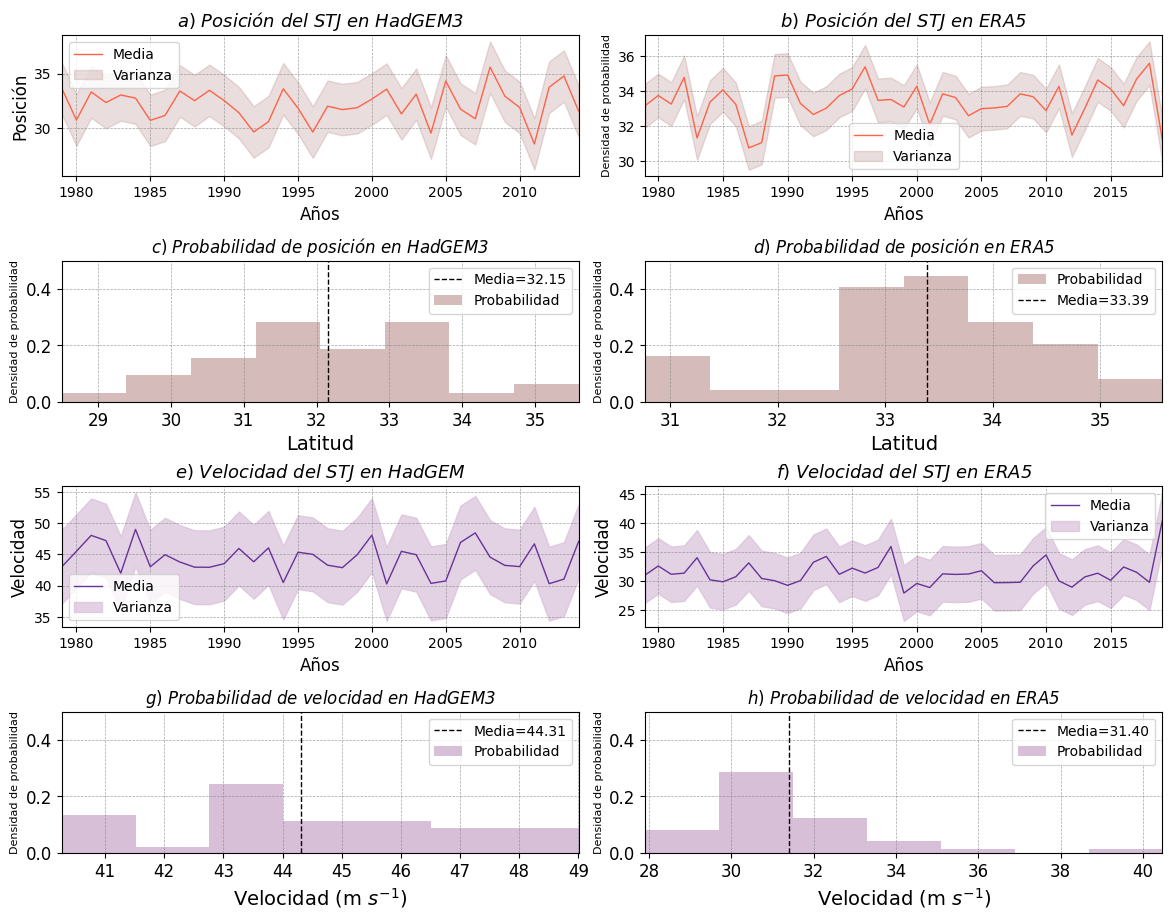

In [49]:
# Creación de subgráficos
fig, axs = plt.subplots(4, 2, figsize=(12, 10))  # Crear 4x2 subgráficos
plt.subplots_adjust(wspace=0.7,hspace=0.2)
axs = axs.flatten()  

# POSICIÓN HadGEM
ax1 = axs[0]  
ax1.plot(mean_POS.year,mean_POS, color='tomato', linewidth=1, label="Media")
ax1.fill_between(mean_POS.year, mean_POS + var_POS, mean_POS - var_POS, color='rosybrown', alpha=0.3, label="Varianza")
ax1.set_xlim([1979,2014])
ax1.set_xlabel("Años", fontsize=12)
ax1.set_ylabel('Posición', fontsize=12)
ax1.tick_params(axis='both', which='major', labelsize=10)
ax1.set_title('a$)$ Posición del STJ en HadGEM3', fontsize=13, color="k", fontstyle='italic')
ax1.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
ax1.legend()

# PROB POSICIÓN HadGEM
ax12 = axs[2]
POS_VEL_p = POS_VEL['Posición del jet en simulación 1']
mediapHG = POS_VEL_p.mean()
ax12.axvline(mediapHG,color = "k", linewidth = 1, linestyle = "dashed",label=f'Media={mediapHG.values:.2f}')
ax12.hist(POS_VEL_p, bins=8, density=True, histtype='stepfilled', facecolor='rosybrown', alpha=0.6,label='Probabilidad')
ax12.set_title('c$)$ Probabilidad de posición en HadGEM3', fontstyle='italic')
ax12.set_xlim([np.min(POS_VEL_p),np.max(POS_VEL_p)])
ax12.set_ylim([0,0.5])
ax12.set_xlabel('Latitud', fontsize=14)
ax12.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
ax12.set_ylabel('Densidad de probabilidad', fontsize=8)
ax12.tick_params(axis='both', which='major', labelsize=12)
ax12.legend()

# POSICIÓN ERA 5
axA = axs[1]
axA.plot(E5mean_POS.year,E5mean_POS, color='tomato', linewidth=1, label="Media")
axA.fill_between(E5mean_POS.year, E5mean_POS + E5var_POS, E5mean_POS - E5var_POS, color='rosybrown', alpha=0.3, label="Varianza")
axA.set_xlim([1979,2019])
axA.set_xlabel("Años", fontsize=12)
axA.set_ylabel('Densidad de probabilidad', fontsize=8)
axA.tick_params(axis='both', which='major', labelsize=10)
axA.set_title('b$)$ Posición del STJ en ERA5', fontsize=13, color="k", fontstyle='italic')
axA.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
axA.legend()

# PROB POSICION ERA 5
axA1 = axs[3]
E5POS_VEL_p = E5POS_VEL['Posición del jet en simulación 1']
axA1.hist(E5POS_VEL_p, bins=8, density=True, histtype='stepfilled', facecolor='rosybrown', alpha=0.6,label='Probabilidad')
media = E5POS_VEL_p.mean()
axA1.axvline(media,color = "k", linewidth = 1, linestyle = "dashed",label=f'Media={media.values:.2f}')
axA1.set_title('d$)$ Probabilidad de posición en ERA5', fontstyle='italic')
axA1.set_xlim([np.min(E5POS_VEL_p),np.max(E5POS_VEL_p)])
axA1.set_ylim([0,0.5])
axA1.set_xlabel('Latitud', fontsize=14)
axA1.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
axA1.set_ylabel('Densidad de probabilidad', fontsize=8)
axA1.tick_params(axis='both', which='major', labelsize=12)
axA1.legend()

# VELOCIDAD JOYA
ax2 = axs[4]
ax2.plot(mean_VEL.year,mean_VEL, color='rebeccapurple', linewidth=1, label="Media")
ax2.fill_between(mean_VEL.year, mean_VEL + var_VEL, mean_VEL - var_VEL, color='thistle',  alpha=0.7, label="Varianza")
ax2.set_xlim([1979,2014])
ax2.set_xlabel("Años", fontsize=12)
ax2.set_ylabel('Velocidad', fontsize=12)
ax2.tick_params(axis='both', which='major', labelsize=10)
ax2.set_title('e$)$ Velocidad del STJ en HadGEM', fontsize=13, color="k", fontstyle='italic')
ax2.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
ax2.legend()

# PROB VELOCIDAD JOYA
ax21 = axs[6]
POS_VEL_v = POS_VEL['Velocidad del jet en simulación 1']
mediavHG = POS_VEL_v.mean()
ax21.axvline(mediavHG,color = "k", linewidth = 1, linestyle = "dashed",label=f'Media={mediavHG.values:.2f}')
ax21.hist(POS_VEL_v, bins=7, density=True, histtype='stepfilled', facecolor='thistle', label='Probabilidad')
ax21.set_title('g$)$ Probabilidad de velocidad en HadGEM3', fontstyle='italic')
ax21.set_xlim([np.min(POS_VEL_v),np.max(POS_VEL_v)])
ax21.set_ylim([0,0.5])
ax21.set_xlabel('Velocidad (m $s^{-1}$)', fontsize=14)
ax21.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
ax21.set_ylabel('Densidad de probabilidad', fontsize=8)
ax21.tick_params(axis='both', which='major', labelsize=12)
ax21.legend()

# VELOCIDAD ERA 5
axB = axs[5]
axB.plot(E5mean_VEL.year,E5mean_VEL, color='rebeccapurple', linewidth=1, label="Media")
axB.fill_between(E5mean_VEL.year, E5mean_VEL + E5var_VEL, E5mean_VEL - E5var_VEL, color='thistle', alpha=0.7, label="Varianza")
axB.set_xlim([1979,2019])
axB.set_xlabel("Años", fontsize=12)
axB.set_ylabel('Velocidad', fontsize=12)
axB.tick_params(axis='both', which='major', labelsize=10)
axB.set_title('f$)$ Velocidad del STJ en ERA5', fontsize=13, color="k", fontstyle='italic')
axB.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
axB.legend()

# PROB VELOCIDAD ERA 5
axB1 = axs[7]
E5POS_VEL_v = E5POS_VEL['Velocidad del jet en simulación 1']
mediavE5 = E5POS_VEL_v.mean()
axB1.axvline(mediavE5,color = "k", linewidth = 1, linestyle = "dashed",label=f'Media={mediavE5.values:.2f}')
axB1.hist(E5POS_VEL_v, bins=7, density=True, histtype='stepfilled', facecolor='thistle',label='Probabilidad')
axB1.set_title('h$)$ Probabilidad de velocidad en ERA5', fontstyle='italic')
axB1.set_xlim([np.min(E5POS_VEL_v),np.max(E5POS_VEL_v)])
axB1.set_ylim([0,0.5])
axB1.set_xlabel('Velocidad (m $s^{-1}$)', fontsize=14)
axB1.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
axB1.set_ylabel('Densidad de probabilidad', fontsize=8)
axB1.tick_params(axis='both', which='major', labelsize=12)
axB1.legend()

# Ajustar el layout y mostrar el gráfico
plt.tight_layout()
plt.subplots_adjust(top=.89)
# plt.suptitle('Estadística básica del STJ',fontsize=14,color="k",fontstyle='italic',fontweight='bold')

plt.savefig('figs/4_Estadísticas.png')

